In [20]:
import pandas as pd
import logging
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, BiTCN
from utilsforecast.plotting import plot_series
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS
import plotly.express as px
import plotly.graph_objects as go
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse
from neuralforecast.losses.pytorch import MQLoss

logging.getLogger('pytorch_lightning').setLevel(logging.INFO)
pd.set_option("display.max_columns", 50)
#torch.set_float32_matmul_precision('high')

### Functions

In [2]:
def plot(df_hist, df_hat, levels=None, model=None):
    """
    Plot historical data and forecasts with optional prediction intervals.
    
    Parameters:
    -----------
    df_hist : DataFrame
        Historical data with columns 'ds' and 'y'
    df_hat : DataFrame
        Forecast data with columns 'ds', 'unique_id', model predictions, and optional prediction intervals
    levels : list of int, optional
        Confidence levels for prediction intervals (e.g., [80, 90])
    """
    dash_styles = ['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot']
    
    # Extract base model names (without -lo-XX or -hi-XX suffixes)
    models = []
    for col in df_hat.columns:
        if col in ["ds", "unique_id"]:
            continue
        # Check if it's a base model (not a level column)
        if not any(col.endswith(f'-lo-{level}') or col.endswith(f'-hi-{level}') 
                   for level in levels or []):
            models.append(col)
    
    fig = go.Figure()
    
    # Add historical data
    fig.add_trace(go.Scatter(
        x=df_hist['ds'], 
        y=df_hist['y'],
        mode='lines',
        name='Historical',
        line=dict(color='black', width=2)
    ))
    
    # Add forecasts and prediction intervals
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    
    for i, model in enumerate(models):
        color = colors[i % len(colors)]
        
        # Add main forecast line
        fig.add_trace(go.Scatter(
            x=df_hat['ds'], 
            y=df_hat[model],
            mode='lines',
            name=model,
            line=dict(dash=dash_styles[i % len(dash_styles)], color=color, width=2)
        ))
        
        # Add prediction intervals if levels are provided
        if levels:
            for level in sorted(levels, reverse=True):  # Plot wider intervals first
                lo_col = f'{model}-lo-{level}'
                hi_col = f'{model}-hi-{level}'
                
                if lo_col in df_hat.columns and hi_col in df_hat.columns:
                    # Add upper bound (invisible line, just for fill)
                    fig.add_trace(go.Scatter(
                        x=df_hat['ds'],
                        y=df_hat[hi_col],
                        mode='lines',
                        line=dict(width=0),
                        showlegend=False,
                        hoverinfo='skip'
                    ))
                    
                    # Add lower bound with fill
                    fig.add_trace(go.Scatter(
                        x=df_hat['ds'],
                        y=df_hat[lo_col],
                        mode='lines',
                        line=dict(width=0),
                        fillcolor=f'rgba({int(color=="blue")*0},{int(color=="red")*255},{int(color=="green")*0},0.{100-level//2})',
                        fill='tonexty',
                        name=f'{model} {level}% PI',
                        hoverinfo='skip'
                    ))
    
    fig.update_layout(
        title='Germany Historical vs Forecast',
        width=1400, 
        height=500,
        xaxis_title='Date',
        yaxis_title='Value',
        hovermode='x unified'
    )
    
    fig.show()

## 1. Load Data

In [3]:
Y_df = pd.read_csv("/mnt/data/oe215/rhindrikson/datasets/load/entsoe/data.csv",
                  parse_dates=["ds"])
futr_df = pd.read_csv("/mnt/data/oe215/rhindrikson/datasets/load/entsoe/futr.csv",
                  parse_dates=['ds'])

## 2. Define Models and fit models

In [27]:
horizon = 24
levels = [80, 90]
nf_models = [NHITS(h=horizon,
                futr_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Future exogenous variables
                input_size=2*365 * horizon,
                max_steps=1000,               # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
                loss=MQLoss(level=levels),
                n_freq_downsample=[2, 1, 1] # Downsampling factors for each stack output
                ),
             LSTM(input_size=5 * horizon,
               h=horizon,                    # Forecast horizon
               futr_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Future exogenous variables
               max_steps=200,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               loss=MQLoss(level=levels),
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),
          BiTCN(h = horizon,
                input_size = 5 * horizon,
               loss=MQLoss(level=levels),
                max_steps=200,
                futr_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Future exogenous variables
                scaler_type = 'robust',
                ),                
         ]
# Instantiate StatsForecast class as sf
nf = NeuralForecast(
    models=nf_models,
    freq='h', 
)


[rank: 0] Seed set to 1
[rank: 0] Seed set to 1
[rank: 0] Seed set to 1


In [28]:
nf.fit(df=Y_df, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 119 M  | train
-------------------------------------------------------
119 M     Trainable params
5         Non-trainable params
119 M     Total params
477.133   Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 51.5 K | train
4 | mlp_decoder  | MLP           | 4.7 K  | train
-------------------------------------------------------
56.2 K    Trainable params
5         Non-trainable params
56.2 K    Total params
0.225     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | MQLoss        | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 96     | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 7.5 K  | train
6  | lin_futr      | Linear        | 80     | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 8.6 K  | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 1.9 K  | train
11 | temporal_lin2 | Linear        | 408    | train
12 | output_lin    | Linear        | 245    | train
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


## 3. Predict and plot

In [29]:
Y_hat_df = nf.predict(futr_df=futr_df).rename(columns=lambda x: x.replace('-median', ''))
Y_hat_df.head(10)

/mnt/home/rmiranda/miniconda3/envs/tms/lib/python3.11/site-packages/neuralforecast/core.py:948: UserWarning:

Dropped 8,742 unused rows from `futr_df`.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,NHITS,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,LSTM,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90,BiTCN,BiTCN-lo-90,BiTCN-lo-80,BiTCN-hi-80,BiTCN-hi-90
0,load,2025-07-01 00:00:00,45118.468750,45293.742188,45163.785156,45386.687500,45569.246094,43627.214844,39256.539062,40048.773438,46928.605469,48250.171875,45761.160156,41577.105469,42216.324219,49575.988281,52047.117188
1,load,2025-07-01 01:00:00,45260.769531,45367.199219,45205.140625,45578.363281,45610.113281,42702.164062,38343.128906,39177.859375,45806.718750,47047.820312,47434.128906,42548.886719,43656.480469,51529.953125,53945.296875
2,load,2025-07-01 02:00:00,46385.269531,46080.117188,46121.265625,46896.234375,46770.753906,42875.480469,38499.507812,39382.644531,45872.214844,47142.316406,48141.328125,42881.960938,44037.359375,52429.128906,54797.613281
3,load,2025-07-01 03:00:00,49327.855469,48783.738281,48888.187500,49934.089844,49780.722656,44976.964844,40613.312500,41621.144531,47986.628906,49329.937500,51483.507812,45309.218750,47077.531250,56155.890625,58072.550781
4,load,2025-07-01 04:00:00,55665.199219,55281.199219,55011.789062,56283.445312,56359.550781,51684.492188,47191.703125,48240.250000,54692.902344,55961.023438,53252.968750,46572.625000,48517.578125,57823.714844,59832.246094
5,load,2025-07-01 05:00:00,61747.320312,61018.140625,60953.367188,62037.000000,61940.894531,58100.472656,53825.757812,54944.078125,60887.097656,61988.500000,56051.808594,49318.734375,51401.207031,60097.265625,61798.039062
6,load,2025-07-01 06:00:00,64187.191406,63244.757812,63710.617188,64430.183594,64242.472656,60635.171875,56696.035156,58019.636719,63325.593750,64346.933594,60386.277344,52071.343750,55165.027344,65137.804688,66292.757812
7,load,2025-07-01 07:00:00,64499.062500,63638.792969,64147.273438,64506.152344,64717.453125,61337.421875,57598.730469,58964.355469,63918.148438,64896.335938,60059.210938,52273.042969,55097.742188,64461.789062,65665.046875
8,load,2025-07-01 08:00:00,64455.242188,63842.328125,64262.898438,64734.566406,65405.382812,61378.582031,57846.328125,59066.769531,63843.871094,64743.859375,63116.457031,54724.546875,57447.804688,67930.960938,68962.867188
9,load,2025-07-01 09:00:00,64710.539062,64328.105469,64626.718750,65003.996094,65757.539062,60813.738281,57568.554688,58531.984375,63169.214844,64018.656250,60998.300781,53753.789062,56114.820312,64856.101562,66367.390625


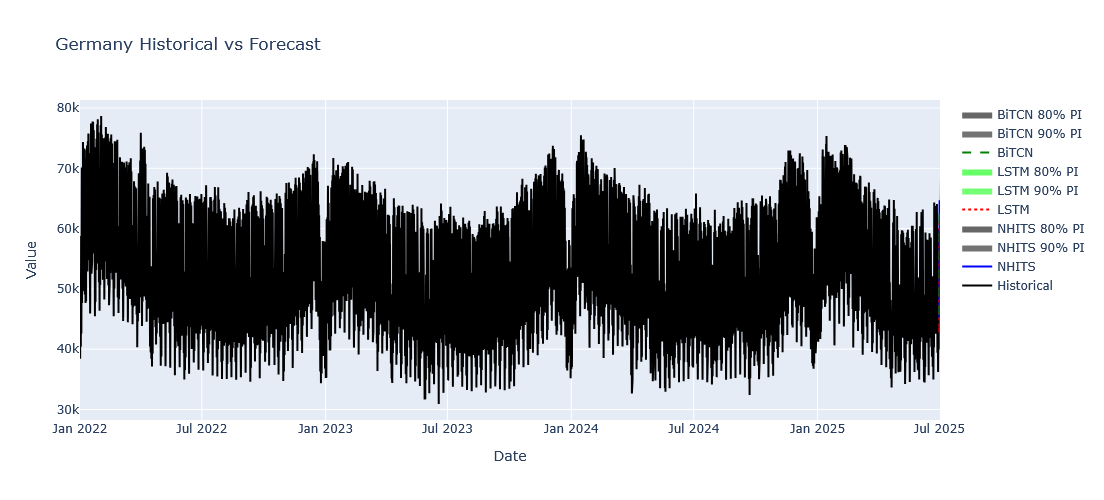

In [30]:
plot(Y_df, Y_hat_df, levels=levels)
# plot_series(Y_df, Y_hat_df, level=levels, models=['LSTM'])

## 4. Cross Validation and Evalutation

In [31]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=24)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 119 M  | train
-------------------------------------------------------
119 M     Trainable params
5         Non-trainable params
119 M     Total params
477.133   Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 51.5 K | train
4 | mlp_decoder  | MLP           | 4.7 K  | train
-------------------------------------------------------
56.2 K    Trainable params
5         Non-trainable params
56.2 K    Total params
0.225     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type          | Params | Mode 
---------------------------------------------------------
0  | loss          | MQLoss        | 5      | train
1  | padder_train  | ConstantPad1d | 0      | train
2  | scaler        | TemporalNorm  | 0      | train
3  | lin_hist      | Linear        | 96     | train
4  | drop_hist     | Dropout       | 0      | train
5  | net_bwd       | Sequential    | 7.5 K  | train
6  | lin_futr      | Linear        | 80     | train
7  | drop_futr     | Dropout       | 0      | train
8  | net_fwd       | Sequential    | 8.6 K  | train
9  | drop_temporal | Dropout       | 0      | train
10 | temporal_lin1 | Linear        | 1.9 K  | train
11 | temporal_lin2 | Linear        | 408    | train
12 | output_lin    | Linear        | 245    | train
-------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
u = cv_df["cutoff"].unique()
print(u)

<DatetimeArray>
['2025-06-27 23:00:00', '2025-06-28 23:00:00', '2025-06-29 23:00:00']
Length: 3, dtype: datetime64[ns]


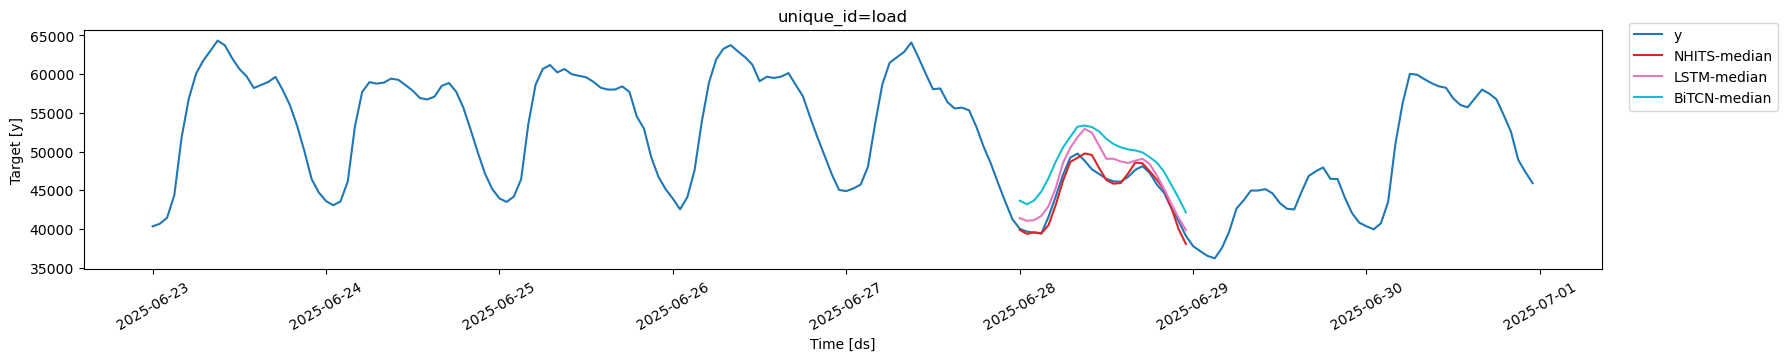

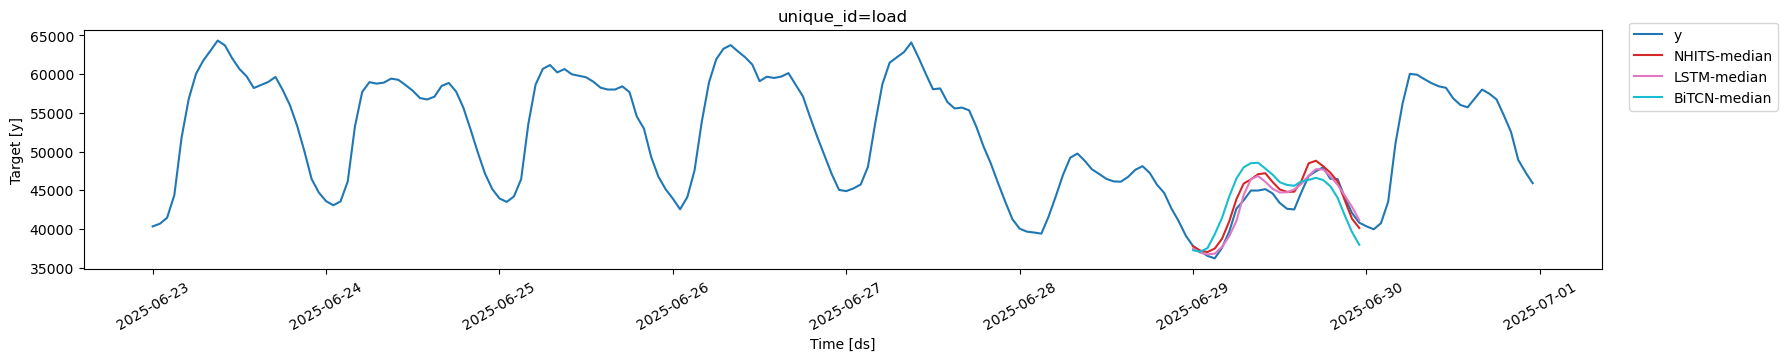

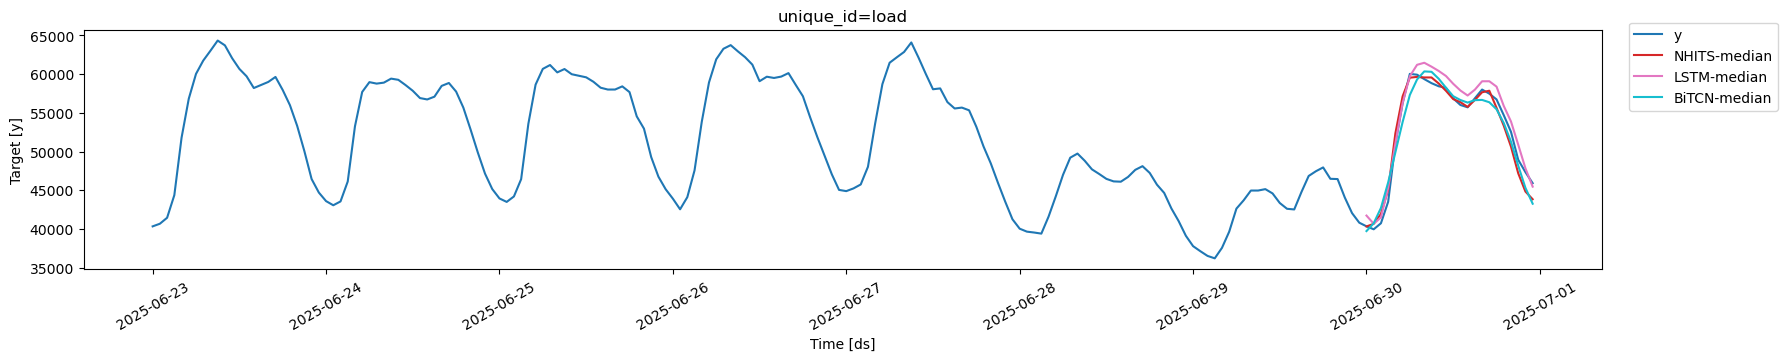

In [33]:
for cutoff in cv_df['cutoff'].unique():
    # plot(Y_df, cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']))
    display(
        plot_series(
            Y_df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=48 * 4, 
        )
    )

# Evaluate

In [34]:
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mse, mae, rmse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head(20)

,unique_id,metric,NHITS-median,LSTM-median,BiTCN-median,best_model
0,load,mse,1.212586e+06,2.521397e+06,8.244762e+06,NHITS-median
1,load,mae,8.719184e+02,1.286976e+03,2.461938e+03,NHITS-median
2,load,rmse,1.101175e+03,1.587891e+03,2.871369e+03,NHITS-median


In [35]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'nr. of unique_ids']
summary_df

,metric,model,nr. of unique_ids
0,mae,NHITS-median,1
1,mse,NHITS-median,1
2,rmse,NHITS-median,1


In [13]:
summary_df.query('metric == "mse"')

,metric,model,nr. of unique_ids
1,mse,NHITS-median,1
